In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import string
import pickle

import gensim


%matplotlib inline
#set column widths t
pd.set_option('display.max_colwidth', -1)

In [2]:
#import data (Thanks to Jen and team for allowing access to the dataset!)
raw = pd.read_csv('/Users/randy/Documents/GitHub/data_files/Online Harassment Dataset/onlineHarassmentDataset.tdf',
                 sep='\t', lineterminator='\r',header = 'infer', encoding='latin-1')

In [3]:
#check the first few rows. Note that there are a bunch of NaN columns
raw.head(3)

,ID,Code,Tweet,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,1,H,@Grumpy_P_Sloth @deanesmay feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her McJob.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,H,1948Army of England helped the Jews to occupy Palestine.After that the Jews killed thousands of Englishmen and returned to England as dogs1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,H,"Dutch Leader Says Europe to collapse In 6 Weeks thnks > @BillGates, @GeorgeSoros, & @FWD_us #AltRight #WhiteGenocide https: / /t.co /rl1mh82jda",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#pull only the Code and Tweet columns
data = raw[['Code','Tweet']]

In [5]:
data['Tweet'] = data['Tweet'].str.lower()

/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Step 1: Data Cleaning

https://medium.com/@dobko_m/nlp-text-data-cleaning-and-preprocessing-ea3ffe0406c1

In [6]:
regex_queries = [
                 '@([A-Za-z0-9_]+)', #Usernames
                'rt\s:\s', #Retweets
                 '(https?:\s?\/\s?\/)(\s)?(www\.)?(\s?)(\w+\.)*([\w\-\s]+\/)*([\w-]+)\/?' # Hyperlinks
                ]

In [7]:
data['Tweet'].replace(regex_queries,'',regex = True, inplace = True)

/Users/randy/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [8]:
#check the dimensions
data.shape

(20360, 2)

In [9]:
#check the first few rows
data.head(3)

,Code,Tweet
0,H,feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her mcjob.
1,H,1948army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs1
2,H,"dutch leader says europe to collapse in 6 weeks thnks > , , & #altright #whitegenocide"


In [10]:
raw.head(3)

,ID,Code,Tweet,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,1,H,@Grumpy_P_Sloth @deanesmay feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her McJob.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,H,1948Army of England helped the Jews to occupy Palestine.After that the Jews killed thousands of Englishmen and returned to England as dogs1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,H,"Dutch Leader Says Europe to collapse In 6 Weeks thnks > @BillGates, @GeorgeSoros, & @FWD_us #AltRight #WhiteGenocide https: / /t.co /rl1mh82jda",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#check that for each value of Code has a value in Tweet
assert data['Code'].isnull().count() == len(data['Tweet'])

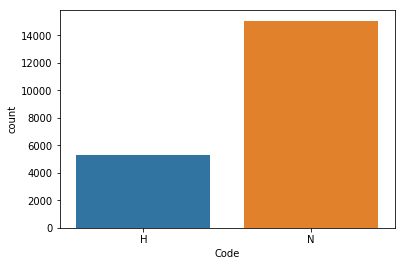

In [12]:
#visualize harassment vs non-harassment cases
sns.countplot(x = 'Code', data=data)

In [13]:
#lowercase all strings
data['Tweet'] = data['Tweet'].str.lower()

/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
s = "some\x00string. with\x15 funny characters"

printable = set(string.printable)
filter(lambda x: x in printable, s)


(-0.5, 399.5, 199.5, -0.5)

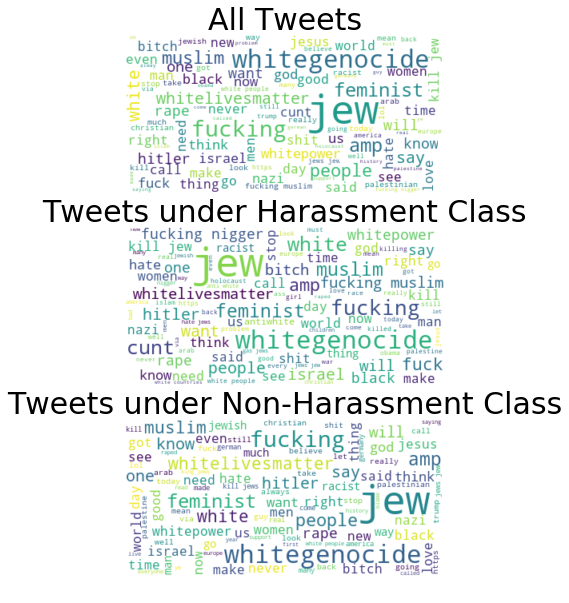

In [15]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Start with one review:
df_H = data[data['Code']=='H']
df_NH = data[data['Code']=='N']
tweet_All = " ".join(review for review in data.Tweet)
tweet_H = " ".join(review for review in df_H.Tweet)
tweet_NH = " ".join(review for review in df_NH.Tweet)

fig, ax = plt.subplots(3, 1, figsize  = (10,10))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)
wordcloud_H = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_H)
wordcloud_NH = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_NH)

# Display the generated image:
ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('All Tweets', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_H, interpolation='bilinear')
ax[1].set_title('Tweets under Harassment Class',fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_NH, interpolation='bilinear')
ax[2].set_title('Tweets under Non-Harassment Class',fontsize=30)
ax[2].axis('off')

In [16]:
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [17]:
#remove non-ascii characters
def remove_non_ascii(text):
    text  = "".join([char for char in text if char in string.printable])
    text = re.sub('[0-9]+', '', text)
    return text

data['non_ascii_tweet'] = data['Tweet'].apply(lambda x: remove_non_ascii(x))
data.head()

/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Code,Tweet,non_ascii_tweet
0,H,feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her mcjob.,feminists argue for raising minimum wage cause a women's studies major needs the $ an hour wage at her mcjob.
1,H,1948army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs1,army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs
2,H,"dutch leader says europe to collapse in 6 weeks thnks > , , & #altright #whitegenocide","dutch leader says europe to collapse in weeks thnks > , , & #altright #whitegenocide"
3,H,"the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .","the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today ."
4,H,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory


In [18]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
#remove the punctuation
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

data['no_punct_tweet'] = data['non_ascii_tweet'].apply(lambda x: remove_punct(x))
data.head()

/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Code,Tweet,non_ascii_tweet,no_punct_tweet
0,H,feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her mcjob.,feminists argue for raising minimum wage cause a women's studies major needs the $ an hour wage at her mcjob.,feminists argue for raising minimum wage cause a womens studies major needs the an hour wage at her mcjob
1,H,1948army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs1,army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs,army of england helped the jews to occupy palestineafter that the jews killed thousands of englishmen and returned to england as dogs
2,H,"dutch leader says europe to collapse in 6 weeks thnks > , , & #altright #whitegenocide","dutch leader says europe to collapse in weeks thnks > , , & #altright #whitegenocide",dutch leader says europe to collapse in weeks thnks altright whitegenocide
3,H,"the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .","the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .",the next day the romans and the jews or watever was like aye fuck that nigga jesus we riding out on his ass today
4,H,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasnt the gas they was expecting memehistory


In [20]:
#tokenize the data
def tokenization(text):
    text = re.split('\W+', text)
    return text

data['Tweet_tokenized'] = data['no_punct_tweet'].apply(lambda x: tokenization(x.lower()))
data.head()

/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Code,Tweet,non_ascii_tweet,no_punct_tweet,Tweet_tokenized
0,H,feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her mcjob.,feminists argue for raising minimum wage cause a women's studies major needs the $ an hour wage at her mcjob.,feminists argue for raising minimum wage cause a womens studies major needs the an hour wage at her mcjob,"[, feminists, argue, for, raising, minimum, wage, cause, a, womens, studies, major, needs, the, an, hour, wage, at, her, mcjob]"
1,H,1948army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs1,army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs,army of england helped the jews to occupy palestineafter that the jews killed thousands of englishmen and returned to england as dogs,"[army, of, england, helped, the, jews, to, occupy, palestineafter, that, the, jews, killed, thousands, of, englishmen, and, returned, to, england, as, dogs]"
2,H,"dutch leader says europe to collapse in 6 weeks thnks > , , & #altright #whitegenocide","dutch leader says europe to collapse in weeks thnks > , , & #altright #whitegenocide",dutch leader says europe to collapse in weeks thnks altright whitegenocide,"[dutch, leader, says, europe, to, collapse, in, weeks, thnks, altright, whitegenocide, ]"
3,H,"the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .","the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .",the next day the romans and the jews or watever was like aye fuck that nigga jesus we riding out on his ass today,"[the, next, day, the, romans, and, the, jews, or, watever, was, like, aye, fuck, that, nigga, jesus, we, riding, out, on, his, ass, today, ]"
4,H,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasnt the gas they was expecting memehistory,"[when, hitler, invited, the, jews, to, the, smoke, session, but, it, wasnt, the, gas, they, was, expecting, memehistory, ]"


In [21]:
#remove STOPWORDS
stopword = nltk.corpus.stopwords.words('english')
#stopword.extend(['yr', 'year', 'woman', 'man', 'girl','boy','one', 'two', 'sixteen', 'yearold', 'fu', 'weeks', 'week',
#               'treatment', 'associated', 'patients', 'may','day', 'case','old'])


In [22]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
data['Tweet_nonstop'] = data['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))
data.head(5)

/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Code,Tweet,non_ascii_tweet,no_punct_tweet,Tweet_tokenized,Tweet_nonstop
0,H,feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her mcjob.,feminists argue for raising minimum wage cause a women's studies major needs the $ an hour wage at her mcjob.,feminists argue for raising minimum wage cause a womens studies major needs the an hour wage at her mcjob,"[, feminists, argue, for, raising, minimum, wage, cause, a, womens, studies, major, needs, the, an, hour, wage, at, her, mcjob]","[, feminists, argue, raising, minimum, wage, cause, womens, studies, major, needs, hour, wage, mcjob]"
1,H,1948army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs1,army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs,army of england helped the jews to occupy palestineafter that the jews killed thousands of englishmen and returned to england as dogs,"[army, of, england, helped, the, jews, to, occupy, palestineafter, that, the, jews, killed, thousands, of, englishmen, and, returned, to, england, as, dogs]","[army, england, helped, jews, occupy, palestineafter, jews, killed, thousands, englishmen, returned, england, dogs]"
2,H,"dutch leader says europe to collapse in 6 weeks thnks > , , & #altright #whitegenocide","dutch leader says europe to collapse in weeks thnks > , , & #altright #whitegenocide",dutch leader says europe to collapse in weeks thnks altright whitegenocide,"[dutch, leader, says, europe, to, collapse, in, weeks, thnks, altright, whitegenocide, ]","[dutch, leader, says, europe, collapse, weeks, thnks, altright, whitegenocide, ]"
3,H,"the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .","the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .",the next day the romans and the jews or watever was like aye fuck that nigga jesus we riding out on his ass today,"[the, next, day, the, romans, and, the, jews, or, watever, was, like, aye, fuck, that, nigga, jesus, we, riding, out, on, his, ass, today, ]","[next, day, romans, jews, watever, like, aye, fuck, nigga, jesus, riding, ass, today, ]"
4,H,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasnt the gas they was expecting memehistory,"[when, hitler, invited, the, jews, to, the, smoke, session, but, it, wasnt, the, gas, they, was, expecting, memehistory, ]","[hitler, invited, jews, smoke, session, wasnt, gas, expecting, memehistory, ]"


In [23]:
#Stemming and Lammitization
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text if len(text) <30]
    return text

data['Tweet_stemmed'] = data['Tweet_nonstop'].apply(lambda x: stemming(x))
data.head()

/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Code,Tweet,non_ascii_tweet,no_punct_tweet,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed
0,H,feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her mcjob.,feminists argue for raising minimum wage cause a women's studies major needs the $ an hour wage at her mcjob.,feminists argue for raising minimum wage cause a womens studies major needs the an hour wage at her mcjob,"[, feminists, argue, for, raising, minimum, wage, cause, a, womens, studies, major, needs, the, an, hour, wage, at, her, mcjob]","[, feminists, argue, raising, minimum, wage, cause, womens, studies, major, needs, hour, wage, mcjob]","[, feminist, argu, rais, minimum, wage, caus, women, studi, major, need, hour, wage, mcjob]"
1,H,1948army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs1,army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs,army of england helped the jews to occupy palestineafter that the jews killed thousands of englishmen and returned to england as dogs,"[army, of, england, helped, the, jews, to, occupy, palestineafter, that, the, jews, killed, thousands, of, englishmen, and, returned, to, england, as, dogs]","[army, england, helped, jews, occupy, palestineafter, jews, killed, thousands, englishmen, returned, england, dogs]","[armi, england, help, jew, occupi, palestineaft, jew, kill, thousand, englishmen, return, england, dog]"
2,H,"dutch leader says europe to collapse in 6 weeks thnks > , , & #altright #whitegenocide","dutch leader says europe to collapse in weeks thnks > , , & #altright #whitegenocide",dutch leader says europe to collapse in weeks thnks altright whitegenocide,"[dutch, leader, says, europe, to, collapse, in, weeks, thnks, altright, whitegenocide, ]","[dutch, leader, says, europe, collapse, weeks, thnks, altright, whitegenocide, ]","[dutch, leader, say, europ, collaps, week, thnk, altright, whitegenocid, ]"
3,H,"the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .","the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .",the next day the romans and the jews or watever was like aye fuck that nigga jesus we riding out on his ass today,"[the, next, day, the, romans, and, the, jews, or, watever, was, like, aye, fuck, that, nigga, jesus, we, riding, out, on, his, ass, today, ]","[next, day, romans, jews, watever, like, aye, fuck, nigga, jesus, riding, ass, today, ]","[next, day, roman, jew, watev, like, aye, fuck, nigga, jesu, ride, ass, today, ]"
4,H,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasnt the gas they was expecting memehistory,"[when, hitler, invited, the, jews, to, the, smoke, session, but, it, wasnt, the, gas, they, was, expecting, memehistory, ]","[hitler, invited, jews, smoke, session, wasnt, gas, expecting, memehistory, ]","[hitler, invit, jew, smoke, session, wasnt, ga, expect, memehistori, ]"


In [28]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text if len(word) <30]
    return text

data['Tweet_lemmatized'] = data['Tweet_nonstop'].apply(lambda x: lemmatizer(x))
data.head()

/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Code,Tweet,non_ascii_tweet,no_punct_tweet,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized
0,H,feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her mcjob.,feminists argue for raising minimum wage cause a women's studies major needs the $ an hour wage at her mcjob.,feminists argue for raising minimum wage cause a womens studies major needs the an hour wage at her mcjob,"[, feminists, argue, for, raising, minimum, wage, cause, a, womens, studies, major, needs, the, an, hour, wage, at, her, mcjob]","[, feminists, argue, raising, minimum, wage, cause, womens, studies, major, needs, hour, wage, mcjob]","[, feminist, argu, rais, minimum, wage, caus, women, studi, major, need, hour, wage, mcjob]","[, feminist, argue, raising, minimum, wage, cause, woman, study, major, need, hour, wage, mcjob]"
1,H,1948army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs1,army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs,army of england helped the jews to occupy palestineafter that the jews killed thousands of englishmen and returned to england as dogs,"[army, of, england, helped, the, jews, to, occupy, palestineafter, that, the, jews, killed, thousands, of, englishmen, and, returned, to, england, as, dogs]","[army, england, helped, jews, occupy, palestineafter, jews, killed, thousands, englishmen, returned, england, dogs]","[armi, england, help, jew, occupi, palestineaft, jew, kill, thousand, englishmen, return, england, dog]","[army, england, helped, jew, occupy, palestineafter, jew, killed, thousand, englishman, returned, england, dog]"
2,H,"dutch leader says europe to collapse in 6 weeks thnks > , , & #altright #whitegenocide","dutch leader says europe to collapse in weeks thnks > , , & #altright #whitegenocide",dutch leader says europe to collapse in weeks thnks altright whitegenocide,"[dutch, leader, says, europe, to, collapse, in, weeks, thnks, altright, whitegenocide, ]","[dutch, leader, says, europe, collapse, weeks, thnks, altright, whitegenocide, ]","[dutch, leader, say, europ, collaps, week, thnk, altright, whitegenocid, ]","[dutch, leader, say, europe, collapse, week, thnks, altright, whitegenocide, ]"
3,H,"the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .","the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .",the next day the romans and the jews or watever was like aye fuck that nigga jesus we riding out on his ass today,"[the, next, day, the, romans, and, the, jews, or, watever, was, like, aye, fuck, that, nigga, jesus, we, riding, out, on, his, ass, today, ]","[next, day, romans, jews, watever, like, aye, fuck, nigga, jesus, riding, ass, today, ]","[next, day, roman, jew, watev, like, aye, fuck, nigga, jesu, ride, ass, today, ]","[next, day, roman, jew, watever, like, aye, fuck, nigga, jesus, riding, as, today, ]"
4,H,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasnt the gas they was expecting memehistory,"[when, hitler, invited, the, jews, to, the, smoke, session, but, it, wasnt, the, gas, they, was, expecting, memehistory, ]","[hitler, invited, jews, smoke, session, wasnt, gas, expecting, memehistory, ]","[hitler, invit, jew, smoke, session, wasnt, ga, expect, memehistori, ]","[hitler, invited, jew, smoke, session, wasnt, gas, expecting, memehistory, ]"


# Step 2: Vectorize (create countVectorizer and TF-IDF Vectorizer)

In [29]:
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

# Starting with countVectorizer:

In [41]:
countVectorizer = CountVectorizer(analyzer=clean_text, ngram_range=(3,3), stop_words='english') 
X = countVectorizer.fit_transform(data['Tweet'])
# print('{} Number of tweets has {} words'.format(X.shape[0], X.shape[1]))
print(f"Dimensions of Document-term matrix: {X.toarray().shape}")
# print(X.get_feature_names())

Dimensions of Document-term matrix: (20360, 19873)


In [42]:
count_vect_df = pd.DataFrame(X.toarray(), columns=countVectorizer.get_feature_names())
count_vect_df.head()

,,aaaaaaarm,aaaaaangel,aaaaallllll,aaayye,aafreedibi,aahahah,aamer,aamerica,aampm,...,ômiddleclassingõ,ônot,ôrape,ôsex,ôswedish,ôtoxic,õ,öìäåâå,øø,û
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# TF-IDF Vectorizer (sklearn method):

In [43]:
# For sklearn, it's VERY similar to how we did CountVectorizer
vectorizer = TfidfVectorizer(analyzer=clean_text, ngram_range=(3,3), stop_words='english')
X_tfidf = vectorizer.fit_transform(data['Tweet'])

# Comparison of countVector to TFIDF:

In [44]:
# How do these two representations compare?
# Let's look at the first 50 dimensions of the first document to gain some intuition

np.set_printoptions(precision=3) # This just makes things a little easier to read

print(f"CountVector: {X.toarray()[0,0:50]}\n\n")

print(f"TFIDF: {X_tfidf.toarray()[0,0:50]}")

CountVector: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


TFIDF: [0.049 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.   ]


# TD-IDF Vectorizer (gensim method):

In [45]:
# Tokenize the documents
# Convert a document into a list of lowercase tokens.
tokenized_docs = [gensim.utils.simple_preprocess(d) for d in data['Tweet']]

# Create a Gensim Dictionary.  This creates an id to word mapping for everything in our vocbulary
# It is NOT the same as the dictionary object in the Python standard library
# index is key, value is word
mydict = gensim.corpora.Dictionary()

# Create a Gensim Corpus object.  This creates a list of tuples for each document.
# The first element of the tuple is the word id, the second is the number of counts
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_docs]

In [46]:
# This creates the doc-term matrix as a numpy array.
# Typically these matrices are HUGE so, it's usuall not a great idea to create the full dense doc-term matrix.
# We do it here to illustrate that you can get the same info as we obtained in scikit-learn!
doc_term_matrix = gensim.matutils.corpus2dense(mycorpus, num_terms=len(mydict))

In [47]:
doc_term_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [48]:
# Creating a tf-idf model is very simple!
tfidf = gensim.models.TfidfModel(mycorpus)
tfidf_matrix = gensim.matutils.corpus2dense(tfidf[mycorpus], num_terms=len(mydict))

In [49]:
tfidf_matrix

array([[0.13 , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.283, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.119, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]], dtype=float32)

# Word2Vec and GloVe

Word2Vec is a very powerful and useful word embedding method.  The math can get a little sticky, but luckily Gensim comes equipped with ways for us to train our own Word2Vec model, or load in a pre-trained word2vec model.  Let's check it out!

In [50]:
tokenized_docs = [gensim.utils.simple_preprocess(d) for d in data['Tweet']]

In [51]:
# size refers to the desired dimension of our word vectors
# window refers to the size of our context window
# sg means that we are using the Skip-gram architecture

model = gensim.models.Word2Vec(tokenized_docs, size=10, window=2,min_count=1, sg=1)

In [52]:
print(model['potato'])

[ 0.003 -0.081 -0.165 -0.152  0.236  0.082  0.061 -0.281 -0.123  0.233]


/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


Training our own model with word2vec is pretty cool, but it requires us to have a large corpus of data.

Fortunately, research groups at Stanford and Google have made their pre-trained word embeddings publicly available for us to use!

Google's word2vec: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

GloVe:  https://nlp.stanford.edu/projects/glove/

Just note that these model's will require ~4 GB of RAM to fit in memory

In [55]:
# Path to where the word2vec file lives
google_vec_file = '/Users/randy/Documents/GitHub/data_files/GoogleNews-vectors-negative300.bin.gz'

In [56]:
# Load it!  This might take a few minutes...
model = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

In [57]:
# We can access individual word vectors using a dictionary-like syntax
model['Metis'][0:5]

array([-0.033, -0.498,  0.061,  0.33 ,  0.22 ], dtype=float32)

In [58]:
# Some cool results!
model.most_similar('meeting' ,topn=2)

[('meetings', 0.757283091545105), ('meeeting', 0.6875465512275696)]

In [59]:
# Here's an analogy task!
# Positive words contribute positively towards the similarity, negative words negatively
model.most_similar(positive=['woman', 'king'], negative=['man']) #man is to king as woman is to...

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431607246399),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]

# Step 3: Reduce Dimensions

#### Each path down the tree gives a different model, so try a lot of things

Model = 1 Vectorizer(countVectorizer or TF-IDF Vectorizer) + 1 Reducer (LSA, LDA, or NMF) + 1 cluster method (K-means, DBSCAN, Hierarchal, and more)

In [ ]:
#put dataframe into a pickle for later use
pickle.dump(data, open( "twitter_harassment.p", "wb" ) )